In [1]:
import numpy as np, xarray as xr
import matplotlib, matplotlib.pyplot as plt
import matplotlib.animation

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

#### Derivatives

In [2]:
def ddx(data, dx, method='cdf2'):
    ''' 
    Partial derivative with respect to x. 
    Method options are 'cdf2' for second-order central difference and 'QUICK' for third-order upwind differencing. 
    Note: GR modified JL scheme to get QUICK working on first derivatives by making scheme pointwise.
    '''
    
    # Central-difference, 2nd-order
    if method == 'cdf2':
        data = data.copy()
        d_dx = np.zeros_like(data)
        d_dx[1:-1, 1:-1] = (data[1:-1, 2:] - data[1:-1, :-2])/(2*dx)
    # QUICK, 3rd-order (reverts to CDF2 at an edge row/column)
    elif method == 'QUICK':
        d_dx = np.zeros_like(data)
        # Iterate over rows: index from 1 to -1 to avoid edges
        for i in range(1, d_dx.shape[0]-1):
            # Iterate over columns: index from 1 to -1 to avoid edges
            for j in range(1, d_dx.shape[1]-1):
                # If index sufficient, use QUICK
                if j > 1:
                    # GR: Lockwood scheme modified to pointwise form (can definitely be more efficient)
                    # Consider d_dx per QUICK to be d_dx = A + B + C
                    A = (data[i, j+1] - data[i, j-1])/(2*dx)
                    B = (data[i, j+1] - 3*data[i, j] + 3*data[i, j-1] - data[i, j-2])/(8*dx)
                    C = dx**2*(1/8 - 1/6)*(data[i, j+1] - 3*data[i, j] + 3*data[i, j-1] - data[i, j-2])/dx**3
                    d_dx[i, j] = A + B + C
                # Else, revert to CDF2
                else:
                    d_dx[i, j] = (data[i, j+1] - data[i, j-1])/(2*dx)
    
    return d_dx

def d2dx2(data, dx, method='cdf2'):
    ''' 
    Second derivative with respect to x. 
    Method options are 'cdf2' for second-order central difference and 'qs' for third-order upwind differencing. 
    '''
    
    if method == 'cdf2':
        data = data.copy()
        d2_dx2 = np.zeros_like(data)
        d2_dx2[1:-1, 1:-1] = (data[1:-1, 2:] - 2*data[1:-1, 1:-1] + data[1:-1, :-2])/(dx**2)
    
    return d2_dx2

def ddz(data, dz, method='cdf2'):
    ''' 
    Partial derivative with respect to z. 
    Method options are 'cdf2' for second-order central difference and 'QUICK' for third-order upwind differencing. 
    Note: GR modified JL scheme to get QUICK working on first derivatives by making scheme pointwise.
    '''
    
    # Central-difference, 2nd-order
    if method == 'cdf2':
        data = data.copy()
        d_dz = np.zeros_like(data)
        d_dz[1:-1, 1:-1] = (data[2:, 1:-1] - data[:-2, 1:-1])/(2*dz)
    # QUICK, 3rd-order (reverts to CDF2 at an edge row/column)
    elif method == 'QUICK':
        d_dz = np.zeros_like(data)
        # Iterate over rows: index from 1 to -1 to avoid edges
        for i in range(1, d_dz.shape[0]-1):
            # Iterate over columns: index from 1 to -1 to avoid edges
            for j in range(1, d_dz.shape[1]-1):
                # If index sufficient, use QUICK
                if i > 1:
                    # GR: Lockwood scheme modified to pointwise form (can definitely be more efficient)
                    # Consider d_dx per QUICK to be d_dx = A + B + C
                    A = (data[i+1, j] - data[i-1, j])/(2*dz)
                    B = (data[i+1, j] - 3*data[i, j] + 3*data[i-1, j] - data[i-2, j])/(8*dz)
                    C = dx**2*(1/8 - 1/6)*(data[i+1, j] - 3*data[i, j] + 3*data[i-1, j] - data[i-2, j])/dz**3
                    d_dz[i, j] = A + B + C
                # Else, revert to CDF2
                else:
                    d_dz[i, j] = (data[i+1, j] - data[i-1, j])/(2*dz)
    
    return d_dz

def d2dz2(data, dz, method='cdf2'):
    ''' 
    Second derivative with respect to x. 
    Method options are 'cdf2' for second-order central difference and 'qs' for third-order upwind differencing. 
    '''
    
    if method == 'cdf2':
        data = data.copy()
        d2_dz2 = np.zeros_like(data)
        d2_dz2[1:-1, 1:-1] = (data[2:, 1:-1] - 2*data[1:-1, 1:-1] + data[:-2, 1:-1])/(dz**2)
    
    return d2_dz2

#### Helper functions

In [3]:
# Helper functions for time derivatives of momentum (u and w)
def F_u(u_in, w_in, method='cdf2'):
    return -(u_in * ddx(u_in, dx, method=method) + w_in * ddz(u_in, dz, method=method) - nu*(d2dx2(u_in, dx) + d2dz2(u_in, dz)))
def F_w(u_in, w_in, method='cdf2'):
    return -(u_in * ddx(w_in, dx, method=method) + w_in * ddz(w_in, dz, method=method) - nu*(d2dx2(w_in, dx) + d2dz2(w_in, dz)))
def F_up(u_in, w_in, p_in, method='cdf2'):
    return -(u_in * ddx(u_in, dx, method=method) + w_in * ddz(u_in, dz, method=method) - ddx(p_in, dx, method=method) - nu*(d2dx2(u_in, dx) + d2dz2(u_in, dz)))
def F_wp(u_in, w_in, p_in, method='cdf2'):
    return -(u_in * ddx(w_in, dx, method=method) + w_in * ddz(w_in, dz, method=method) - ddz(p_in, dz, method=method) - nu*(d2dx2(w_in, dx) + d2dz2(w_in, dz)))

#### Visualization functions

In [19]:
def diagnostic_plots(data, time_index):
    
    '''
    Takes 'data' as an xArray Dataset and plots u, w, and p at timestep 'time_index'.
    '''
    
    fig, axes = plt.subplots(figsize=(9, 3), ncols=3, sharey=True)

    # Plot horizontal velocity
    ax_u = axes[0]
    ax_u.pcolormesh(x, z, data['u'].isel(t=time_index), norm=matplotlib.colors.CenteredNorm(), cmap='bwr')
    ax_u.set_title('u(t = {0})\nmin: {1:.2f}, max: {2:.2f}'.format(time_index, np.nanmin(data['u'].isel(t=time_index)[1:-1, 1:-1]), 
                                                                   np.nanmax(data['u'].isel(t=time_index)[1:-1, 1:-1])), fontsize=9)

    # Plot vertical velocity
    ax_z = axes[1]
    ax_z.pcolormesh(x, z, data['w'].isel(t=time_index), 
                       norm=matplotlib.colors.CenteredNorm(), cmap='bwr')
    ax_z.set_title('w(t = {0})\nmin: {1:.2f}, max: {2:.2f}'.format(time_index, np.nanmin(data['w'].isel(t=time_index)[1:-1, 1:-1]), 
                                                                   np.nanmax(data['w'].isel(t=time_index)[1:-1, 1:-1])), fontsize=9)

    # Plot pressure
    ax_pres = axes[2]
    ax_pres.pcolormesh(x, z, data['p'].isel(t=time_index), 
                       norm=matplotlib.colors.CenteredNorm(), cmap='bwr')
    ax_pres.set_title('p(t = {0})\nmin: {1:.2f}, max: {2:.2f}'.format(time_index, np.nanmin(data['p'].isel(t=time_index)[1:-1, 1:-1]), 
                                                                      np.nanmax(data['p'].isel(t=time_index)[1:-1, 1:-1])), fontsize=9)
    
    plt.show()

#### Initialization function

In [5]:
def init(N, U_0, dt=0.01, rho_0=1, time_max=10):
    
    # Define time axis
    time = range(0, time_max)

    # Define the basis vector (x-axis, z-axis)
    x, z = [np.arange(min(bounds_z), max(bounds_x), dx),
            np.arange(min(bounds_z), max(bounds_z), dz)]
    # Crete meshgrid
    X, Z = np.meshgrid(x, z)

    ''' Initial values. '''
    # Density
    rho_init = np.full(shape=X.shape, fill_value=rho_0)
    rho = np.full(shape=(len(time), X.shape[0], X.shape[1]), fill_value=np.nan)
    rho[0, :, :] = rho_init
    # Pressure
    p_init = 0
    p = np.full(shape=(len(time), X.shape[0], X.shape[1]), fill_value=np.nan)
    p[0, :, :] = p_init
    # Horizontal velocity
    u_init = np.full(shape=(len(time), X.shape[0], X.shape[1]), fill_value=0, dtype=float)
    u_init[0, 0, :] = U_0
    # Vertical velocity
    w_init = np.full(shape=(len(time), X.shape[0], X.shape[1]), fill_value=0, dtype=float)

    # Build and populate xArray Dataset
    data = xr.Dataset(coords={'x': (['x'], x), 'z': (['z'], z),'t': (['t'], time)},
                      data_vars={'p': (['t', 'z', 'x'], p, {'long_name': 'pressure', 'units': 'Pa'}),
                                 'rho': (['t', 'z', 'x',], rho, {'long_name': 'density', 'units': 'kg m^{-3}'})})
    data['u'] = (['t', 'z', 'x'], u_init, {'long_name': 'horizontal velocity', 'units': 'm s^{-1}'})
    data['w'] = (['t', 'z', 'x'], w_init, {'long_name': 'vertical velocity', 'units': 'm s^{-1}'})
    
    return N, x, z, data

#### Direct inversion method

In [6]:
def direct_inversion(u, w, p, N, dx, dz, dt, U=None, nu=None, mode='explicit_euler'):
    
    '''
    Direct inversion for a linear matrix system to solve the Poisson equation for pressure, Ap = b.
    A is an M x M matrix (M = N_x * N_z), b is an M-sized vector. We're solving for pressure (p).
    '''

    # Initialize Jacobian
    M = N
    A = np.identity(M**2, dtype=float) # 5-point stencil
    b = np.full(shape=M**2, fill_value=0, dtype=float) # Equals the right-hand side of the differential (commonly called f)
    
    ''' First derivatives (2nd-order CDF). '''
    du_dx = ddx(u.values, dx, method='cdf2')
    du_dz = ddz(u.values, dz, method='cdf2')
    dw_dx = ddx(w.values, dx, method='cdf2')
    dw_dz = ddz(w.values, dz, method='cdf2')
    
    ''' Second derivatives (2nd-order CDF). '''
    d2u_dx2 = d2dx2(u.values, dx, method='cdf2')
    d2u_dz2 = d2dz2(u.values, dz, method='cdf2')
    d2w_dx2 = d2dx2(w.values, dx, method='cdf2')
    d2w_dz2 = d2dz2(w.values, dz, method='cdf2')
    
    row = 0
    # Iterate over each point (each point corresponds to a row in matrix A)
    for i in range(0, N): # iterate over rows
        for j in range(0, N): # iterate over columns
            
            # Capture the iterand values
            u_, w_ = u.isel(x=j, z=i), w.isel(x=j, z=i)
            
            # Fill in identity diagonal
            A[row, row] = -4
            # Get indices for +/- x and y values
            ym, yp, xm, xp = row - M, row + M, row - 1, row + 1
            
            ''' Set boundary conditions. '''
                
            # Handle corners
            # Top left
            if (row // M == 0) and (row % M == 0):
                # print('Top left')
                A[xp, row] = 1
                A[yp, row] = 1
                b[row] = 0 + p[i, j] # Dirichlet top, Neumann left BC
            # Top right
            elif (row // M == 0) and ((row % M) == (M-1)):
                # print('Top right')
                A[xm, row] = 1
                A[yp, row] = 1
                b[row] = 0 + p[i, j] # Dirichlet top, Neumann right BC
            # Bottom left
            elif (row // M == (M-1)) and (row % M == 0):
                # print('Bottom left')
                A[xp, row] = 1
                A[ym, row] = 1
                b[row] = p[i, j] + p[i, j] # Neumann bottom BC, Neumann left BC
            # Bottom right
            elif (row // M == (M-1)) and ((row % M) == (M-1)):
                # print('Bottom right')
                A[xm, row] = 1
                A[ym, row] = 1
                b[row] = p[i, j] + p[i, j] # Neumann bottom BC, Neumann right BC
            # Top center
            elif (row // M == 0) and ((row % M != 0) and ((row % M) != (M-1))):
                # print('Top center')
                A[xm, row] = 1
                A[xp, row] = 1
                A[yp, row] = 1
                b[row] = 0 # Dirichlet top BC
            # Bottom center
            elif (row // M == (M-1)) and ((row % M != 0) and ((row % M) != (M-1))):
                # print('Bottom center')
                A[xm, row] = 1
                A[xp, row] = 1
                A[ym, row] = 1
                b[row] = p[i, j] # Neumann bottom BC
            # Left center
            elif (row % M == 0) and ((row // M != 0) and (row // M != (M-1))):
                # print('Left center')
                A[xp, row] = 1
                A[ym, row] = 1
                A[yp, row] = 1
                b[row] = p[i, j] # Neumann left BC
            # Right center
            elif ((row % M) == (M-1)) and ((row // M != 0) and (row // M != (M-1))):
                # print('Right center')
                A[xm, row] = 1
                A[ym, row] = 1
                A[yp, row] = 1
                b[row] = p[i, j] # Neumann right BC
            # Non-edge
            else:
                # print('Non-edge')
                A[xm, row] = 1
                A[xp, row] = 1
                A[ym, row] = 1
                A[yp, row] = 1
                
                if not nu:
                    nu = 0.1
                if not U:
                    U = 1
                    
                Re = U/nu
                d3u_dx3  = (d2u_dx2[i, j+1] - d2u_dx2[i, j-1])/(2*dx)
                d3u_dxz2 = (d2u_dz2[i, j+1] - d2u_dz2[i, j-1])/(2*dx)
                d3w_dx2z = (d2w_dx2[i+1, j] - d2w_dx2[i-1, j])/(2*dz)
                d3w_dz3  = (d2w_dz2[i+1, j] - d2w_dz2[i-1, j])/(2*dz)
                
                d2u_dxz = (du_dz[i, j+1] - du_dz[i, j-1])/(2*dx)
                d2w_dxz = (dw_dx[i+1, j] - dw_dx[i-1, j])/(2*dz)
                
                u_, w_ = u.isel(x=j, z=i), w.isel(x=j, z=i)
                
                if mode == 'explicit_euler':
                    b[row] = dx**2*((1/dt)*(du_dx[i, j] + dw_dz[i, j]) + (1/Re)*(d3u_dx3 + d3u_dxz2 + d3w_dx2z + d3w_dz3) - (du_dx[i, j]**2 + dw_dz[i, j]**2 + 2*dw_dx[i, j]*du_dz[i, j]))
                elif mode == 'rk_proj':
                    x_comp = du_dx[i, j] + dt*(-du_dx[i, j]**2 - u_*d2u_dx2[i, j] - dw_dx[i, j]*du_dz[i, j] - w_*d2u_dxz + nu*(d3u_dx3 + d3u_dxz2))
                    z_comp = dw_dz[i, j] + dt*(-dw_dx[i, j]*du_dz[i, j] - u_*d2w_dxz - dw_dz[i, j]**2 - w_*d2w_dz2[i, j] + nu*(d3w_dx2z + d3w_dz3))
                    b[row] = dx**2*(x_comp + z_comp)/dt
                                               
            row += 1

    # print(A, '\n\n', b, '\n')
    p = (np.linalg.inv(A) @ b).reshape(M, M)
    return p

#### Iterative point-by-point Poisson solver

In [7]:
def pressure_solver(p, u, w, dx, dz, dt, factor=1, f=0):
    
    ''' Iterative solver for the Poisson equation for pressure. '''
    
    p = p.copy().values
    u = u.copy().values
    w = w.copy().values
    
    pn = p.copy()
    
    # Get LHS factor
    B = -2*(1/dx**2 + 1/dz**2)
    
    # Define derivatives
    du_dx = np.zeros_like(u)
    du_dx[1:-1, 1:-1] = (u[1:-1, 2:] - u[1:-1, :-2])/(2*dx)
    du_dz = np.zeros_like(w)
    du_dz[1:-1, 1:-1] = (u[2:, 1:-1] - u[:-2, 1:-1])/(2*dz)
    dw_dx = np.zeros_like(u)
    dw_dx[1:-1, 1:-1] = (w[1:-1, 2:] - w[1:-1, :-2])/(2*dx)
    dw_dz = np.zeros_like(w)
    dw_dz[1:-1, 1:-1] = (w[2:, 1:-1] - w[:-2, 1:-1])/(2*dz)
    
    # Get divergence of v
    div_v = (du_dx + dw_dz)/(factor*dt)
    # Get the pressure residual
    b = -du_dx**2 - 2*dw_dx*du_dz - dw_dz**2
    
    for q in range(100):
        pn = p.copy()
        
        # Get pressure terms from the LHS
        p_x = np.zeros_like(pn)
        p_x[1:-1, 1:-1] = (pn[1:-1, 2:] + pn[1:-1, :-2])/(dx**2)
        p_z = np.zeros_like(pn)
        p_z[1:-1, 1:-1] = (pn[2:, 1:-1] + pn[:-2, 1:-1])/(dz**2)
        # Sum
        p[1:-1, 1:-1] = (1/B)*(-p_x[1:-1, 1:-1] - p_z[1:-1, 1:-1] + div_v[1:-1, 1:-1] + dx*dz*b[1:-1, 1:-1])

        # Impose boundary conditions
        p[:, -1] = p[:, -2]  # dp/dx = 0 at x = 2
        p[-1, :] = p[-2, :]  # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]    # dp/dx = 0 at x = 0
        p[0, :] = 0          # p = 0 at y = 2
        
    return p

#### Run script

1. Initialize domain and boundary conditions
2. For a given timestep:
- Prognostic equations for $u$, $w$  (decomposed version of Durran, Eq. 8.3) with: 
     - a spatial discretization scheme (this script uses 2nd-order CDF currently)
     - a temporal discretization scheme (this script uses 1st-order explicit Euler currently)
- Solve elliptic PDE for $p$ with direct matrix inversion or a point-by-point iteration(use Durran, Eq. 8.14)
3. Plot the final timestep

Timestep 10 at time 0.005s, Re = 98.04
Timestep 20 at time 0.010s, Re = 98.04
Timestep 30 at time 0.015s, Re = 98.04
Timestep 40 at time 0.020s, Re = 98.04
Timestep 50 at time 0.025s, Re = 98.04
Timestep 60 at time 0.029s, Re = 98.04
Timestep 70 at time 0.034s, Re = 98.04
Timestep 80 at time 0.039s, Re = 98.04
Timestep 90 at time 0.044s, Re = 98.04
Timestep 100 at time 0.049s, Re = 98.04
Timestep 110 at time 0.054s, Re = 98.04
Timestep 120 at time 0.059s, Re = 98.04
Timestep 130 at time 0.064s, Re = 98.04
Timestep 140 at time 0.069s, Re = 98.04
Timestep 150 at time 0.074s, Re = 98.04
Timestep 160 at time 0.078s, Re = 98.04
Timestep 170 at time 0.083s, Re = 98.04
Timestep 180 at time 0.088s, Re = 98.04
Timestep 190 at time 0.093s, Re = 98.04
Timestep 200 at time 0.098s, Re = 98.04
Timestep 210 at time 0.103s, Re = 98.04
Timestep 220 at time 0.108s, Re = 98.04
Timestep 230 at time 0.113s, Re = 98.04
Timestep 240 at time 0.118s, Re = 98.04
Timestep 250 at time 0.123s, Re = 98.04
Timestep 

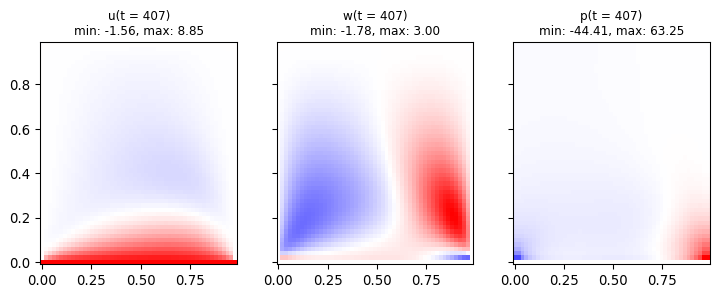

In [22]:
''' Initial parameters. '''
# Density
rho_0 = 1
# Number of grid points
N = 51
# Kinematic viscosity
nu = 0.1
# Edge velocity, initial
U = 10
# Coriolis parameter
f = 0

# Define number of grid point
N_x, N_z = N, N
# Define the bounds for the domain
bounds_x, bounds_z = [0, 1], [0, 1]
# Define grid spacing
dx = (max(bounds_x) - min(bounds_x))/N_x
dz = (max(bounds_z) - min(bounds_x))/N_z

# CFL number
cfl = 0.5
# Timestep as a function of the CFL number
dt = cfl/(U/dx + U/dz)

# End time for simulation (shouldn't exceed for steady-state)
end_time = 0.2
# Maximum timesteps
time_max = int(np.ceil(end_time/dt))

# Pick timestepping method ('explicit Euler', 'projection', or 'leapfrog')
timestep_method = 'QUICK'
# Perturbation methods
perturbation = 'constant'

# Get initial data
N, x, z, data = init(N, U, dt, rho_0=rho_0, time_max=time_max)
# Step through time
for iter_count, time_index in enumerate(range(1, time_max)):
    # Print outputs every M steps
    M = 10
    if time_index % M == 0:
        print('Timestep {0} at time {1:.3f}s, Re = {2:.2f}'.format(time_index, time_index*dt, U*max(x)/nu))

    # Get previous timestep values
    p_prev = data['p'].isel(t=time_index-1)
    u_prev = data['u'].isel(t=time_index-1)
    w_prev = data['w'].isel(t=time_index-1)
    
    ''' Update each prognostic field. '''
    
    # Explicit Euler timestepping method
    if timestep_method == 'explicit_euler':
        # Horizontal velocity (u); [u_(n+1) = u_n - dt*F], where F is some function 
        u_next = u_prev + dt*(F_u(u_prev.values, w_prev.values) - ddx(p_prev.values, dx))
        # Vertical velocity (w); [u_(n+1) = u_n - dt*F], where F is some function 
        w_next = w_prev + dt*(F_w(u_prev.values, w_prev.values) - ddz(p_prev.values, dz))
        # Solve for pressure
        # p = direct_inversion(u_prev, w_prev, p_prev,  N, dx, dz, dt=dt)
        p = pressure_solver(p_prev, u_prev, w_prev, dx, dz, dt)
        
    # Projection timestepping method
    elif timestep_method == 'projection':
        # Copy values
        u, w = u_prev.copy().values, w_prev.copy().values
        # First derivatives
        du_dx = ddx(u, dx, method='cdf2')
        du_dz = ddz(u, dz, method='cdf2')
        dw_dx = ddx(w, dx, method='cdf2')
        dw_dz = ddz(w, dz, method='cdf2')
        # Second derivatives
        d2u_dx2 = d2dx2(u, dx, method='cdf2')
        d2u_dz2 = d2dz2(u, dz, method='cdf2')
        d2w_dx2 = d2dx2(w, dx, method='cdf2')
        d2w_dz2 = d2dz2(w, dz, method='cdf2')
    
        # Get intermediate velocity step (u* in the Chorin method)
        u_ = u_prev + dt*(-u*du_dx - w*du_dz + nu*(d2u_dx2 + d2u_dz2) + f*w_prev)
        w_ = w_prev + dt*(-u*dw_dx - w*dw_dz + nu*(d2w_dx2 + d2w_dz2) - f*u_prev)
        # Update pressure and get spatial derivatives
        p = pressure_solver(p_prev, u_, w_, dx, dz, dt, f=f)
        dp_dx = ddx(p, dx, method='cdf2')
        dp_dz = ddz(p, dz, method='cdf2')
        # Update velocity to the next timestep
        u_next = u_ - dt*dp_dx
        w_next = w_ - dt*dp_dz
        
    # Leapfrog timestepping method
    elif timestep_method == 'leapfrog':
        if time_index < 3:
            # Horizontal velocity (u); [u_(n+1) = u_n - dt*F], where F is some function 
            u_next = u_prev + dt*(F_u(u_prev.values, w_prev.values) - ddx(p_prev.values, dx))
            # Vertical velocity (w); [u_(n+1) = u_n - dt*F], where F is some function 
            w_next = w_prev + dt*(F_w(u_prev.values, w_prev.values) - ddz(p_prev.values, dz))
            # Solve for pressure
            p = direct_inversion(u_prev, w_prev, p_prev, N, dx, dz, dt=dt)
        else:
            # Get previous timesteps: u(t-2) and w(t-2)
            um = data['u'].isel(t=time_index-2)
            wm = data['w'].isel(t=time_index-2)
            # Get updated timestep
            u_ = um + 2*dt*F_u(u_prev.values, w_prev.values)
            w_ = wm + 2*dt*F_w(u_prev.values, w_prev.values)
            # Get pressure and pressure gradient
            p = pressure_solver(p_prev, u_, w_, dx, dz, dt, factor=1)
            dp_dx = np.zeros_like(u_)
            dp_dx[1:-1, 1:-1] = (p[1:-1, 2:] - p[1:-1, :-2])/(2*dx)
            dp_dz = np.zeros_like(u_)
            dp_dz[1:-1, 1:-1] = (p[2:, 1:-1] - p[:-2, 1:-1])/(2*dz)
            # Update velocities
            u_next = u_ - 2*dt*dp_dx
            w_next = w_ - 2*dt*dp_dz
    elif timestep_method == 'QUICK':
        # Horizontal velocity (u); [u_(n+1) = u_n - dt*F], where F is some function 
        u_next = u_prev + dt*(F_u(u_prev.values, w_prev.values, method='QUICK') - ddx(p_prev.values, dx, method='QUICK'))
        # Vertical velocity (w); [u_(n+1) = u_n - dt*F], where F is some function 
        w_next = w_prev + dt*(F_w(u_prev.values, w_prev.values, method='QUICK') - ddz(p_prev.values, dz, method='QUICK'))
        # Solve for pressure
        p = pressure_solver(p_prev, u_prev, w_prev, dx, dz, dt)
        
    ''' Flow cases. '''
    if perturbation == 'oscillating':
        u_next[0, :] = U*(1-2*np.sin(4*time_index/time_max))
    elif perturbation == 'switch':
        if time_index*dt < end_time/2:
            u_next[0, :] = -U
        else:
            u_next[0, :] = U
    elif perturbation == 'accelerating':
        u_next[0, :] = U
        U += 0.1
    elif perturbation == 'decelerating':
        if time_index > 10:
            u_next[0, :] = u_next[0, :]/(time_index)
    elif perturbation == 'decelerating+viscosity':
        if time_index > 10:
            u_next[0, :] = u_next[0, :]/(time_index)
            nu += 0.001
    else:
        u_next[0, :] = U
    # Update velocities
    data['u'][{'t': time_index}] = u_next
    data['w'][{'t': time_index}] = w_next
    data['p'][{'t': time_index}] = p
    
diagnostic_plots(data, time_index)